Using TensorFlow backend.
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: 
  warnings.warn

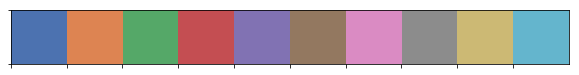

In [1]:
# compute
import numpy as np
import pandas as pd
# import keras

# data io
import glob
# import deepdish as dd
import sys
sys.path.append('../')

# image
# import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette(sns.color_palette('deep'))
sns.palplot(sns.color_palette())

# spykes
# from spykes.neuropop import NeuroPop
# from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
# import V4pyutils as V4
from V4pyutils import *

from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from tqdm import tqdm
# from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
import pickle
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']

art_df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions')

df_neurons = pd.read_pickle('../02-preprocessed_data/M3/data_to_combine_across_sessions')

nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

In [3]:
diff_df_all_real =  pd.read_pickle('desat_diff_from_sat_predictions_real_XGB.pickle')
sat_nat_features = pd.read_pickle('../02-preprocessed_data/M3/sat_weighted_hue_hist_16bins_new')

# Motivate the paper

0. Find some neurons with strong NS color modulation but low WFH correlations
0. Show the top WFH responses
0. Show the receptive field of the top NS responses

In [4]:
# Re-create the scatter of NS modulation with correlation

In [5]:
corrs, vgg_mod = pickle.load(            open("corr_vs_vgg_mod.p","rb"))
wfh_mod = pickle.load( open("neuron_color_modulation.p","r"))
wfh_mod[0]=0

Text(0,0.5,'VGG modulation index')

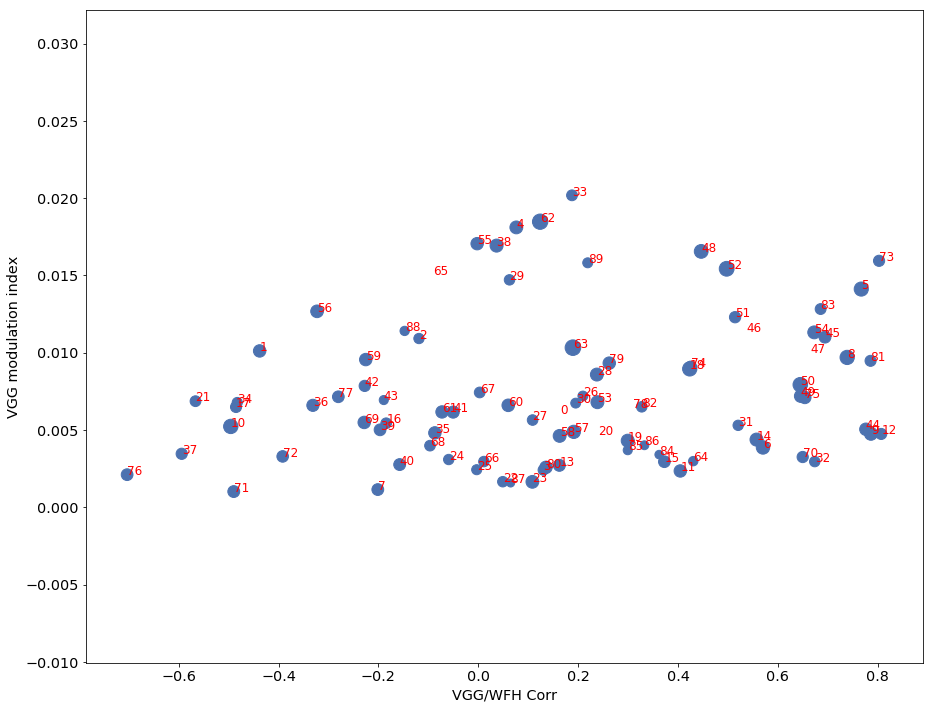

In [6]:
plt.figure(figsize=(15,12))
plt.scatter(corrs,vgg_mod, s = wfh_mod**.5*200)
for point in range(90):
     plt.text(corrs[point],vgg_mod[point], str(point), 
              color="red", fontsize=12)


plt.xlabel("VGG/WFH Corr")
plt.ylabel("VGG modulation index")

In [7]:
candidates = [21,1,56,55,38,4,62,33,24,27,10,59,26]
candidates = [1, 39, 9]

#### Now for some select neurons, show the top stimuli

In [10]:
def get_WFH(hue, deg = False):
    #convert to deg. Mapping [-pi pi] to [0 360]
    hue_deg = hue if deg else int(hue*180/np.pi+180)
    stimpath='../V4pydata'
    impath = 'stimuli/M3/Hues'
    imname = "img{:0>3}.jpg".format(hue_deg)
    I = get_image(stimpath=stimpath, impath=impath, imname=imname)
    I[0,0,0] = hue_deg
    return I

colors = []
for c in range(360):
    stim = get_WFH(c, True)
    colors.append(stim[10,10,:]/255.)

    
from matplotlib import colors as col
cmap = col.ListedColormap(colors)


In [11]:
art_XGB = pd.read_pickle('art_XGB.p')

In [27]:
def lowess_smooth(hue,response,lowess_frac = .2, tied_ends = True, num_boots = None):
    """Take a tuning curve and smooth it."""
    if tied_ends == False:
        lowess = sm.nonparametric.lowess
        smoothed_data = lowess(np.squeeze(response), hue, frac=lowess_frac)
        
    else:
        # concatenate data with itself to approximate a circular hue wheel.
        # We'll take just the middle section
        y_data = np.hstack((response, response))
        x_data = np.hstack((hue, hue+2*np.pi))
        l = x_data.shape[0]


        # User lowess smoothing to smooth data and model
        lowess = sm.nonparametric.lowess
        smoothed_data = lowess(np.squeeze(y_data), x_data, frac=lowess_frac)
        
        bounds = None
        if num_boots is not None:
            straps = np.zeros((num_boots, x_data.shape[0]))
            for i in range(num_boots):
                subset_x, subset_y = bootstrap2(x_data, np.squeeze(y_data))
                this_smoothed = lowess(subset_y, subset_x, frac=lowess_frac, )
                straps[i,:] = this_smoothed[:,1]

            perc5 = np.percentile(straps,5,axis=0,)
            perc95 = np.percentile(straps,95,axis=0,)
            
            perc5 = perc5[l//4:(3*l)//4]
            perc95 = perc95[l//4:(3*l)//4]
            l2 = len(perc5)//2
            perc5 = np.roll(perc5, l2)
            perc95 = np.roll(perc95, l2)
            bounds = perc5,perc95

        # Downsample now just to middle
        smoothed_data = smoothed_data[l//4:(3*l)//4,:]
        x_data = x_data[l//4:(3*l)//4]
        y_data = y_data[l//4:(3*l)//4]

        # and get x axis back to around 0
        smoothed_data[:,0] += -np.pi
        x_data[0] += -np.pi

        # and roll the y data back to original range
        l = len(smoothed_data[:,0])//2
        smoothed_data[:,1] = np.roll(smoothed_data[:,1], l)
        y_data = np.roll(y_data,l)
    
    return smoothed_data[:,0],smoothed_data[:,1], bounds

def plot_TC(art_XGB, neuron, ticks =None):
    plt.figure(figsize = (10,4))
    plt.subplot(121)
    hue,tuning_curve,(y_low,y_high) = lowess_smooth(art_XGB.iloc[:,0][neuron]['hue'], 
                        art_XGB.iloc[:,0][neuron]['spike_counts']/art_XGB.iloc[:,0][neuron]['duration'],
                                                                    num_boots = 100)
    n_every = len(y_low)//40
    cc = [sns.color_palette(n_colors = 50)[0]] +sns.color_palette(n_colors = 50)[2:]

    plt.plot(hue[::n_every],tuning_curve[::n_every], lw=2, c = cc[0],)
    plt.fill_between(hue[::n_every],y_low[::n_every],y_high[::n_every],
                     alpha = 0.2 , color = cc[0])
    ax  = plt.gca()

    colorline(np.linspace(-np.pi,np.pi,len(hue)),
              np.zeros(len(hue)),
              linewidth=16, cmap = cmap)
    
    if not (ticks == None):
        for loc in ticks:
            plt.plot([loc,loc],[0,5])

    ax.set_xticks([-np.pi,0,np.pi], minor=False)
    ax.set_xticklabels(['$-\pi$','0','$\pi$'])
    plt.ylabel('Spikes/s', fontsize = 18)
    plt.xlabel('Hue', fontsize = 18)
    ax.set_yticks([0,5,10,15], minor=False)
    
    ax2 = plt.subplot(122)
    slopes, errs,_ = get_slopes(neuron_id, diff_df_all_real)
    hues = np.linspace(-np.pi,np.pi,8)
    plt.plot(hues,slopes,'-o')

    colorline(np.linspace(-np.pi,np.pi,len(hue)),
              np.zeros(len(hue)),
              linewidth=6, cmap = cmap)

    ax.set_xticks([-np.pi,0,np.pi], minor=False)
    ax.set_xticklabels(['$-\pi$','0','$\pi$'])
    plt.xlabel('Hue', fontsize = 18)
    
    plt.tight_layout()
    plt.show()

    

In [28]:
def get_best_responses(df_neurons, df_data, nat_features,  session = 'art', model_df = None,
                         neuron_id = 0, n_stimuli = 10,  skip_first = 0):
    """
    
    
    This handles a lot of the tricky data preparation. For each neuron, it looks up which trials were valid
    (this is different per neuron because we throw out sessions in which we're suspicious of neural drift for that neuron)
    and then prepares the data vectors.
    
    
    
    Inputs:
    ======
    df_neurons = dataframe with neural data
    df_data = dataframe with all data. Must contain 'session_number' column
    nat_features = A features dataframe. we just use this to get the `accepted_indices` column
    
    
    Options:
    ========
   
    session = art or nat? If nat, we return the image corresponding to the receptive field.
    neuron_id = obviously
    n_stimuli = how many stimuli to return
    model_df = result of a `prep_data_and_fit_neurons`. If given, returns the best 10 _predicted_
                    responses, as well as the image section in the RF

    
    Outputs:
    ========
    A list of the top N stimuli, ordered by the neural response
    
    """
   
    
    which_session = session + '_sessions'

    ### Get proper X and Y data ~~~~~~~~~~~~~~~

    # Extract session numbers
    sessions_of_interest = df_neurons.loc[neuron_id][which_session]
    neuron_name = df_neurons['name'][neuron_id]

    # Grab relevant data
    if session is 'art':

        df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest)]

        covariates =  ['predictors.hue', 
                       'predictors.col', 
                       'predictors.row', 
                       'predictors.hue_prev', 
                       'predictors.stim_dur', 
                       'predictors.off_to_onset_times']

        # Get covariates
        X = df_sessions_of_interest[covariates].values  
        # for plotting
        x_data = df_sessions_of_interest['predictors.hue'].values


    else:  # get natural feature
        in_category = nat_features['accepted_indices']
        df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest)& \
                                             df_data.index.isin(in_category)]        
      
    # Select sessions of interest
    indices_of_interest = np.array(df_sessions_of_interest.index)

    # Get spike counts
    Y = df_sessions_of_interest[neuron_name].values

    # Rescale by the stimulus duration for all methods
    l = 'predictors.stim_dur' if session =='art' else 'predictors.fix_duration'
    Y = Y/df_sessions_of_interest[l].values
#     Y = Y.values    
    
    if model_df is not None:
        Y = model_df.iloc[neuron_id,0]['predicted_spike_counts']
        
    assert(len(indices_of_interest)==len(Y))
        

    ## now see the best
    best_n = np.argsort(Y)[::-1][skip_first:n_stimuli+skip_first]
    stimresp =[]
    for resp_num in best_n:
        # get fixation number
        fx = indices_of_interest[resp_num]
           
        if session == "nat":
            stim = get_NS_image(fx, df_data)
        else:
            hue = df_sessions_of_interest['predictors.hue'].iloc[resp_num]
            stim = get_WFH(hue)
           
        stimresp.append((stim,Y[resp_num]))
           
    return stimresp



def get_NS_image(fx, df,stimpath='../V4pydata',):
    """Given a fixation and stimulus dataset, return the stimulus."""
    radius=200
    RF_block=14
    # Open image file
    impath = df.loc[fx]['im.path']
    imname = df.loc[fx]['im.name']
    filename = stimpath+'/'+impath+'/'+imname
    
    try:
        I = plt.imread(filename)
    except IOError:
        print("{} not found".format(filename))
        I = np.ones((1000,1000,3))

    # Check for missing image file
    assert(not (I == None)) 

    # Cut relevant fixation (maybe again)
    r, c = int(df.loc[fx]['predictors.row']), int(df.loc[fx]['predictors.col'])
    I_fix = I[r-radius:r+radius, c-radius:c+radius, :]
    

    ### Just get the receptive field
    
    # Grid image into blocks
    Block = grid_image(I_fix, [4, 4])
    RF_image = Block[RF_block]
 
    return RF_image

def actual_hue_colormap():
    colors = []
    for c in range(360):
        stim = get_WFH(c, True)
        colors.append(stim[10,10,:]/255.)

    cmap = col.ListedColormap(colors)
    return cmap


def visualize_stims(stimresp, art = False, saveto = None,
                    rates = True):
    s = 2
    n_stim = len(stimresp_NS)
    plt.figure(figsize=(s*n_stim,s))
    if art:
        for i,(stim,resp) in enumerate(stimresp):
            plt.subplot(1,n_stim, i+1)
            hue = stim[0,0,0]
            stim[0,0,0] = stim[0,0,1]
            plt.imshow(stim)
            if rates:
                plt.title("{:.2f}\n {:.2f}".format(resp, np.pi*hue/180-np.pi))
            plt.axis("off")
    else:
        for i,(stim,resp) in enumerate(stimresp):
            plt.subplot(1,n_stim, i+1)
            plt.axis("off")
            try:
                plt.imshow(stim)
                if rates:
                    plt.title("{:.2f}".format(resp))
            except:
                continue
    if saveto is not None:
        plt.savefig(saveto, transparent=True)
    plt.show()
    


In [14]:

def build_9x9_grid(stimresp, saveto = None):
    plt.figure(figsize = (4,4))
    for i,(stim,resp) in enumerate(stimresp[:9]):
        plt.subplot(3,3, i+1)
        plt.axis("off")
        try:
            plt.imshow(stim)
        except:
            continue
    plt.tight_layout(pad = 0,  h_pad=-3, w_pad=-3,)
#     plt.tight_layout()
    if saveto is not None:
        plt.savefig(saveto, transparent = True)
    plt.show()
    

In [15]:
nat_hist_art_model = prep_data_and_fit_neurons(df_neurons, nat_df, model='art_model_mean_corrected', session = 'nat', 
                          nat_features = sat_nat_features, image_feature = 'hue.histogram', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=False,art_XGB=art_XGB)

1it [00:00,  5.10it/s]../V4pyutils.py:902: RuntimeWarning: invalid value encountered in log
  L1 = np.sum(y * np.log(eps + yhat) - yhat)
../V4pyutils.py:903: RuntimeWarning: invalid value encountered in log
  L1_v = y * np.log(eps + yhat) - yhat
90it [00:34,  3.89it/s]


In [16]:
nat_hist_XGB = pd.read_pickle('nat_hist_XGB.p')
nat_hist_GLM_sat = pd.read_pickle('nat_hist_GLM_sat.p')


/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/ipykernel_launcher.py:118: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


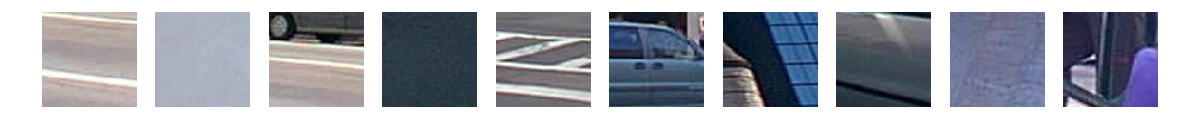

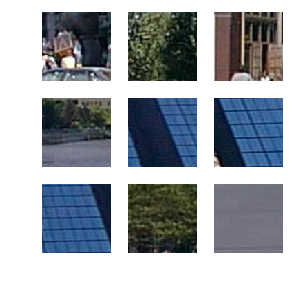

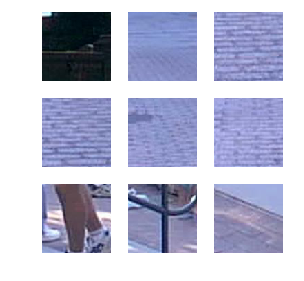

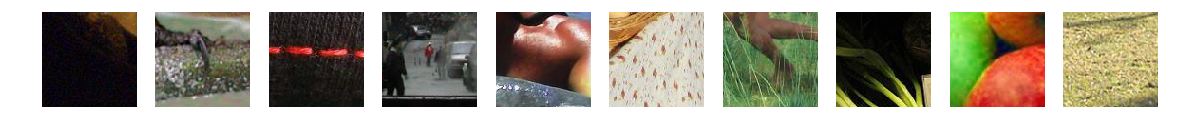

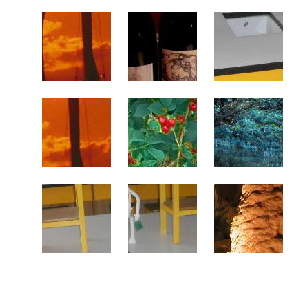

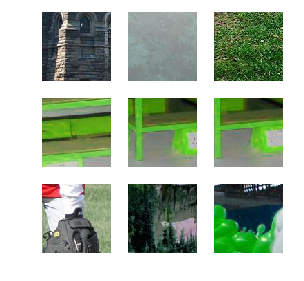

In [17]:
for neuron_id in [1, 9]:
#     plot_TC(art_XGB, neuron_id)
    stimresp_NS_wfhpred = get_best_responses(df_neurons, nat_df, sat_nat_features, session = 'nat', 
                         model_df = nat_hist_art_model, skip_first = 0,
                         neuron_id = neuron_id,n_stimuli = 10)
    stimresp_NS = get_best_responses(df_neurons, nat_df, sat_nat_features, session = 'nat', 
                         neuron_id = neuron_id, n_stimuli = 10, skip_first = 0)
    stimresp_NS_xgb = get_best_responses(df_neurons, nat_df, sat_nat_features, session = 'nat', 
                         model_df = nat_hist_XGB, skip_first = 0,
                         neuron_id = neuron_id,n_stimuli = 9)
    stimresp_NS_glm = get_best_responses(df_neurons, nat_df, sat_nat_features, session = 'nat', 
                         model_df = nat_hist_GLM_sat, skip_first = 0,
                         neuron_id = neuron_id,n_stimuli = 9)
    
    
#     visualize_stims(stimresp_WFH, art = True)
    visualize_stims(stimresp_NS,rates = False,
#                    saveto = 'final_figures/fig_2/neuron_{}_actual.pdf'.format(neuron_id)
                  )
#     build_9x9_grid(stimresp_NS_wfhpred,
#                    saveto = 'final_figures/fig_1_mystery/neuron_{}_wfpred.png'.format(neuron_id)
#                   )
    build_9x9_grid(stimresp_NS_xgb, 
#                    saveto = 'final_figures/fig_2/neuron_{}_xgb_NS.pdf'.format(neuron_id)
                  )
    build_9x9_grid(stimresp_NS_glm, 
#                    saveto = 'final_figures/fig_2/neuron_{}_glm_NS.pdf'.format(neuron_id)
                  )
    
    

In [436]:
_, _, all_prefit_models_real, _  = pickle.load(open("fit_XGB_CNN_8cv_1,9.p",'rb'))
vgg_model = all_prefit_models_real[0]

#### Extract the mean hue of each

In [90]:
def plot_TC_ticks(art_XGB, neuron, ticks =None, saveas = None):
    fig = plt.figure()
    hue,tuning_curve,(y_low,y_high) = lowess_smooth(art_XGB.iloc[:,0][neuron]['hue'], 
                        art_XGB.iloc[:,0][neuron]['spike_counts']/art_XGB.iloc[:,0][neuron]['duration'],
                                                                    num_boots = 100)
    n_every = len(y_low)//40
    cc = [sns.color_palette(n_colors = 50)[0]] +sns.color_palette(n_colors = 50)[2:]

    plt.plot(hue[::n_every],tuning_curve[::n_every], lw=2, c = cc[0],)
    plt.fill_between(hue[::n_every],y_low[::n_every],y_high[::n_every],
                     alpha = 0.2 , color = cc[0])
    ax  = plt.gca()

    colorline(np.linspace(-np.pi,np.pi,len(hue)),
              np.zeros(len(hue)),
              linewidth=16, cmap = cmap)
    
    # add tickes
    _,ymax = ax.get_ylim()
    if not (ticks == None):
        for loc in ticks:
            i = int(loc/np.pi*180+180)
            plt.plot([loc,loc],[0,ymax/10], c = cmap.colors[i])

        ax  = plt.gca()
      
    simpleaxis(ax)
    ax.set_xticks([-np.pi,0,np.pi], minor=False)
    ax.set_ylim(bottom = 0)
    ax.set_xlim(left = -np.pi, right=np.pi)
    ax.set_xticklabels(['$-\pi$','0','$\pi$'], fontsize = 18)
    ax.set_yticklabels(ax.get_yticklabels(),minor = True,
                       fontsize = 18)
    
    plt.ylabel('Spikes/s', fontsize = 24)
    plt.xlabel('Hue', fontsize = 24)
    
    
    
    plt.tight_layout()
    fig.patch.set_alpha(0)
    if saveas is not None:
        plt.savefig(saveas, facecolor=fig.get_facecolor())
    
    plt.show()


In [91]:
from astropy.stats import circmean as as_circmean
def get_mean_hue_weighted(I):
    """Returns the mean hue of image I, but with each pixels;s hue contribution weighted by its distance
    from the LUV long axis.
    
    Inputs:
    =======
    I = RGB image"""
    
    # Convert to Luv
    I = I.astype(np.float32)
    I *= 1./255
    Luv = rgb2luv(I)
    
    # get hues
    hue = np.arctan2(Luv[:,:,2], Luv[:,:,1])
    # and "saturation": dist from the LUV central axis
    saturation = np.sqrt(np.square(Luv[:,:,2]) + np.square(Luv[:,:,1]))
    
    mean_hue = as_circmean(hue.flatten(), weights = saturation.flatten())
    
    return mean_hue

/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/ipykernel_launcher.py:118: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


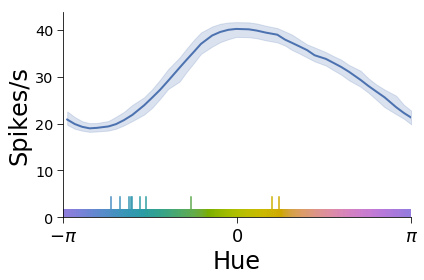

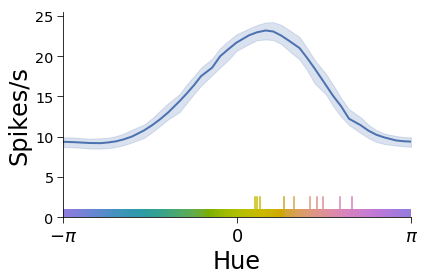

In [92]:
for neuron_id in [1, 9]:
    stimresp_NS = get_best_responses(df_neurons, nat_df, sat_nat_features, session = 'nat', 
                         neuron_id = neuron_id, n_stimuli = 10, skip_first = 0)
    
    
    hues = []
    for i,(stim,resp) in enumerate(stimresp_NS):
        mean_hue = get_mean_hue_weighted(stim)
        hues.append(mean_hue)
    
    
    plot_TC_ticks(art_XGB, neuron_id, ticks = hues, 
                  saveas = "final_figures/fig_1_mystery/art_TC_with_ticks_neuron_{}.pdf".format(neuron_id))
    

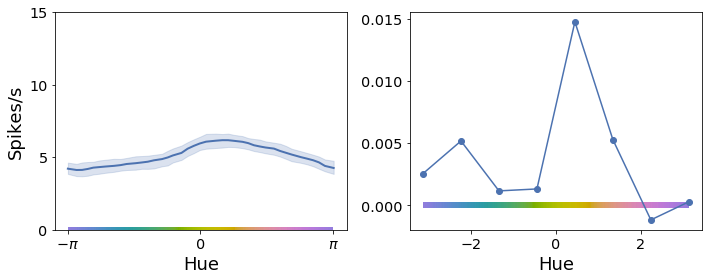

/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/ipykernel_launcher.py:126: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


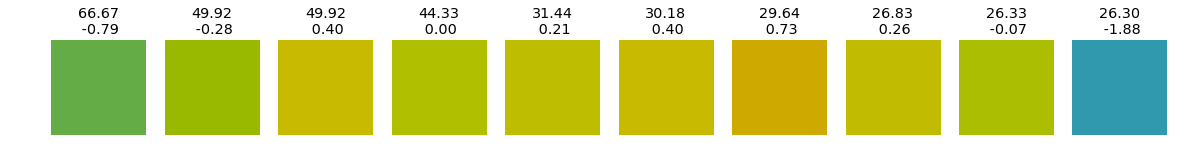

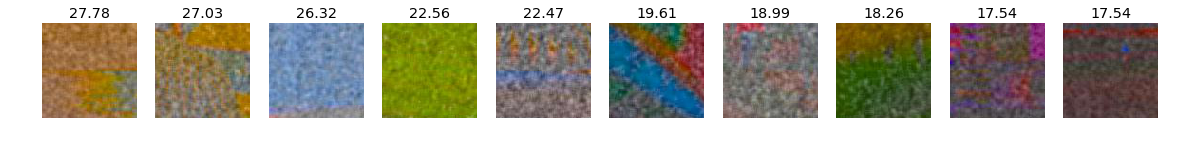

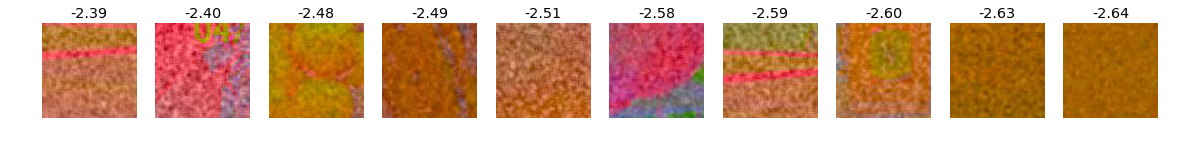

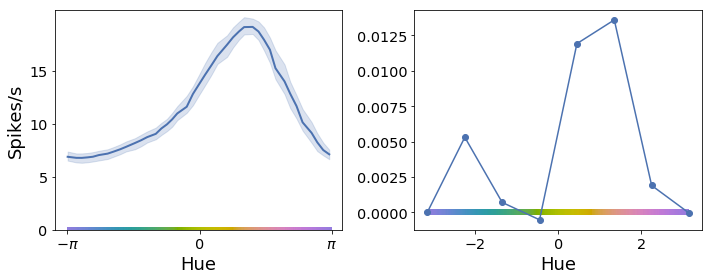

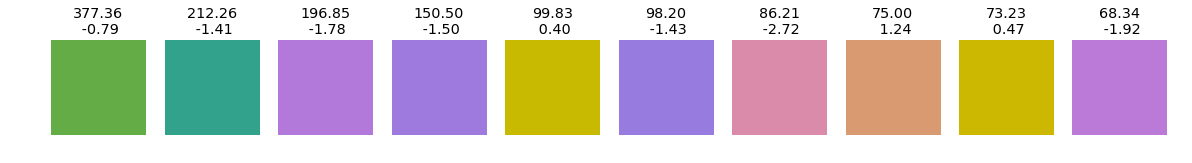

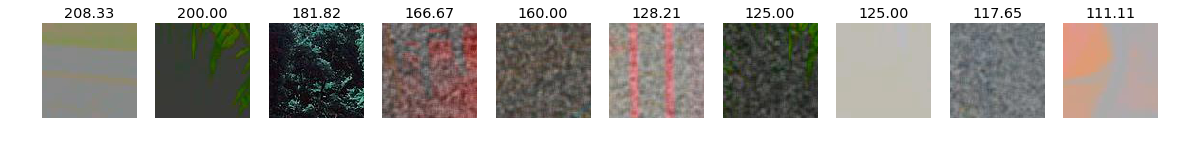

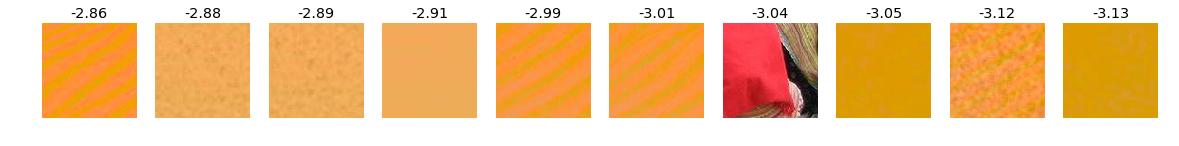

In [371]:
# goods
for neuron_id in [73,5]:
    plot_TC(art_XGB, neuron_id)
    stimresp_NS_wfhpred = get_best_responses(df_neurons, nat_df, sat_nat_features, session = 'nat', 
                         model_df = nat_hist_art_model, skip_first = 5,
                         neuron_id = neuron_id,n_stimuli = 10)
    stimresp_WFH = get_best_responses(df_neurons, art_df, sat_nat_features, session = 'art', 
                         neuron_id = neuron_id, n_stimuli = 10)
    stimresp_NS = get_best_responses(df_neurons, nat_df, sat_nat_features, session = 'nat', 
                         neuron_id = neuron_id, n_stimuli = 10, skip_first = 5)

    
    visualize_stims(stimresp_WFH, art = True)
    visualize_stims(stimresp_NS)
    visualize_stims(stimresp_NS_wfhpred)
    

In [374]:
2%3

2

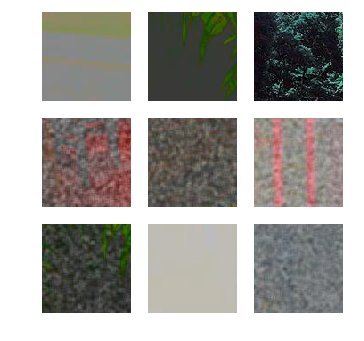

In [397]:
build_9x9_grid(stimresp_NS)